# *eda-0-choose-sure-pixel.ipynb*

# Read in CDL, reproject, and identify a sure pixel

- Read in CDL
- Reproject and resample CDL to HLS projection (UTM)
- Investigate land covers
- Identify sure pixel
- Future: save down reprojected CDLs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import os


In [2]:
from rasterio.warp import reproject

## California 10SFH Almonds

Read in and reproject all CDLs
- specify years as range(2018,2023)
- specify state as 'Iowa' or 'California'
- specify tile as '10SFH' or '15TVG'
- output is a dictionary of CDLs: state_dict which includes each year as a key and each array as a value
- for each state-year, need to read in the national CDL, then use the reproject function to reproject and clip it to the HLS tile

In [19]:
def read_cdl(years=range(2018,2023),
             tile='10SFH',
             also_return_affines=False):
    
    if tile=='10SFH':
        full = 'HLS.L30.T10SFH.2020007T183941.v2.0'
        hls_path = f'../data/hls_23feb23/L30/2020/10/S/F/H/{full}/{full}.B03.tif'
    if tile=='15TVG':
        full = 'HLS.L30.T15TVG.2020007T170001.v2.0'
        hls_path = f'../data/hls_23feb23/L30/2020/15/T/V/G/{full}/{full}.B03.tif'
    
    src_hls = rasterio.open(hls_path)
    
    dict_of_arrays = {}
    dict_of_affines = {}
    
    for year in years:
        print(f'Working on CDL from year {year}...')
        cdl_path = f'../data/NationalCDL_{year}/{year}_30m_cdls.tif'
        with rasterio.open(cdl_path) as src_cdl:
            array, affine = reproject(source=src_cdl.read(1), # this is an array
              destination=src_hls.read(1), # this is another array
              src_transform=src_cdl.transform, # this is the transform corresponding to first array
              src_crs=src_cdl.crs, # this is the crs corresponding to first array
              dst_transform=src_hls.transform, # this is the transform corresponding to second array
              dst_crs=src_hls.crs, # this is the crs corresponding to second array
              )
        
        dict_of_arrays[str(year)] = array
        dict_of_affines[str(year)] = affine
        
    print('Finished with all CDLs.')
    
    if not also_return_affines:
        return dict_of_arrays
    if also_return_affines:
        return dict_of_arrays, dict_of_affines

In [6]:
dict_cdl_10SFH = read_cdl(years=range(2018,2023),
                     tile='10SFH')

Working on CDL from year 2018...
Working on CDL from year 2019...
Working on CDL from year 2020...
Working on CDL from year 2021...
Working on CDL from year 2022...
Finished with all CDLs.


Verify that no two years are the same:

In [7]:
for year1 in range(2018,2023):
    for year2 in range(2018,2023):
        print(f'Comparing {year1} with {year2}:')
        print((dict_cdl_10SFH[str(year1)] == dict_cdl_10SFH[str(year2)]).all())

Comparing 2018 with 2018:
True
Comparing 2018 with 2019:
False
Comparing 2018 with 2020:
False
Comparing 2018 with 2021:
False
Comparing 2018 with 2022:
False
Comparing 2019 with 2018:
False
Comparing 2019 with 2019:
True
Comparing 2019 with 2020:
False
Comparing 2019 with 2021:
False
Comparing 2019 with 2022:
False
Comparing 2020 with 2018:
False
Comparing 2020 with 2019:
False
Comparing 2020 with 2020:
True
Comparing 2020 with 2021:
False
Comparing 2020 with 2022:
False
Comparing 2021 with 2018:
False
Comparing 2021 with 2019:
False
Comparing 2021 with 2020:
False
Comparing 2021 with 2021:
True
Comparing 2021 with 2022:
False
Comparing 2022 with 2018:
False
Comparing 2022 with 2019:
False
Comparing 2022 with 2020:
False
Comparing 2022 with 2021:
False
Comparing 2022 with 2022:
True


Read in crop type codes:

In [8]:
cdlcnc = pd.read_csv('../data/CDL_codes_names_colors.csv', header=3)

#### Explore most common land cover and crop types

In [9]:
def explore_common_crops(array, ref, threshold=200000):
    vals, counts = np.unique(array, return_counts=True)

    tops = []
    for i in range(len(vals)):
        if counts[i]>threshold:
            name = cdlcnc.loc[ref['Codes']==vals[i],'Class_Names'].values[0]
            tops.append((vals[i],counts[i], name))
    print(np.array(tops))

In [10]:
# readout for all 5 years
for year in range(2018,2023):
    print(f'--- Readout for year {year} ---')
    explore_common_crops(array=dict_cdl_10SFH[str(year)],
                         ref=cdlcnc)

--- Readout for year 2018 ---
[['1' '546268' 'Corn']
 ['3' '261571' 'Rice']
 ['24' '223683' 'Winter Wheat']
 ['36' '464655' 'Alfalfa']
 ['37' '433386' 'Other Hay/Non Alfalfa']
 ['54' '219335' 'Tomatoes']
 ['61' '661094' 'Fallow/Idle Cropland']
 ['69' '593572' 'Grapes']
 ['76' '324641' 'Walnuts']
 ['111' '389325' 'Open Water']
 ['121' '746649' 'Developed/Open Space']
 ['122' '505299' 'Developed/Low Intensity']
 ['123' '693101' 'Developed/Med Intensity']
 ['141' '397098' 'Deciduous Forest']
 ['142' '1254695' 'Evergreen Forest']
 ['152' '573714' 'Shrubland']
 ['176' '3476084' 'Grass/Pasture']]
--- Readout for year 2019 ---
[['1' '450987' 'Corn']
 ['3' '215933' 'Rice']
 ['24' '346368' 'Winter Wheat']
 ['36' '562369' 'Alfalfa']
 ['37' '294296' 'Other Hay/Non Alfalfa']
 ['54' '264849' 'Tomatoes']
 ['61' '589445' 'Fallow/Idle Cropland']
 ['69' '621849' 'Grapes']
 ['76' '440280' 'Walnuts']
 ['111' '410500' 'Open Water']
 ['121' '671929' 'Developed/Open Space']
 ['122' '517050' 'Developed/Low I

Note that 2018 and 2019 had significantly less almonds than the next few years - we'll characterize that in a moment.

### Create crop masks

Making masks looks like this:

almonds_mask = cdlrpj_array == 75  
grapes_mask = cdlrpj_array == 69  
corn_mask = cdlrpj_array == 1  
tomatoes_mask = cdlrpj_array == 54  
evergreen_mask = cdlrpj_array == 142  
devel_med_mask = cdlrpj_array == 123  

You just need to know the code corresponding to the crop. For example, almonds is 75. (Future: could programatically refer to cdlcnc to look up the code for each name.)

In [11]:
mask_dict_almonds = {}
for year in range(2018,2023):
    mask_dict_almonds[str(year)] = dict_cdl_10SFH[str(year)]==75

Text(0.5, 1.0, 'Map of Almonds in 2022 (tile 10SFH)')

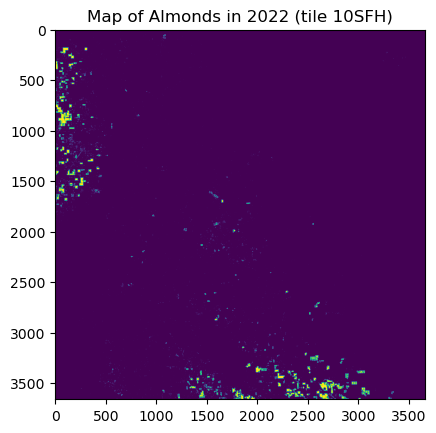

In [12]:
plt.imshow(mask_dict_almonds['2018'])
plt.title(f'Map of Almonds in {year} (tile 10SFH)')

In [13]:
save_loc = '../figures/eda-maps'

for year in range(2018,2023):
    file_name = f'almonds_mask_{year}.png'
    plt.figure(figsize=(20, 20))
    plt.imshow(mask_dict_almonds[str(year)])
    plt.title(f'Map of Almonds in {year} (tile 10SFH)', size=20)
    plt.savefig(f'{save_loc}/{file_name}', bbox_inches='tight')
    plt.close()

Looking at these, it appears that between 2019 and 2020, the CDL got much better at picking up smaller almond orchards (this is a guess: perhaps a bunch of small orchards just popped up that year, but that sounds unlikely.)

### Test a certain point

In [14]:
def is_sure_crop(crop_mask, coordinates):
    r = coordinates[0]
    c = coordinates[1]
    
    rows = [r-1, r, r+1]
    columns = [c-1, c, c+1]
    
    truth_list = []
    for row in rows:
        for column in columns:
            TF = crop_mask[row,column]
            print(f'The pixel at {row},{column} is the right crop:', TF)
            truth_list.append(TF)
    sum(truth_list)
    print(f'{sum(truth_list)} out of 9 pixels are the right crop.')

In [15]:
is_sure_crop(crop_mask=mask_dict_almonds['2018'], coordinates=[900,50])

The pixel at 899,49 is the right crop: True
The pixel at 899,50 is the right crop: True
The pixel at 899,51 is the right crop: True
The pixel at 900,49 is the right crop: True
The pixel at 900,50 is the right crop: True
The pixel at 900,51 is the right crop: True
The pixel at 901,49 is the right crop: True
The pixel at 901,50 is the right crop: True
The pixel at 901,51 is the right crop: True
9 out of 9 pixels are the right crop.


In [16]:
for year in range(2018,2023):
    print(f'--- Readout for year {year} ---')
    is_sure_crop(mask_dict_almonds[str(year)],[900,50])

--- Readout for year 2018 ---
The pixel at 899,49 is the right crop: True
The pixel at 899,50 is the right crop: True
The pixel at 899,51 is the right crop: True
The pixel at 900,49 is the right crop: True
The pixel at 900,50 is the right crop: True
The pixel at 900,51 is the right crop: True
The pixel at 901,49 is the right crop: True
The pixel at 901,50 is the right crop: True
The pixel at 901,51 is the right crop: True
9 out of 9 pixels are the right crop.
--- Readout for year 2019 ---
The pixel at 899,49 is the right crop: True
The pixel at 899,50 is the right crop: True
The pixel at 899,51 is the right crop: True
The pixel at 900,49 is the right crop: True
The pixel at 900,50 is the right crop: True
The pixel at 900,51 is the right crop: True
The pixel at 901,49 is the right crop: True
The pixel at 901,50 is the right crop: True
The pixel at 901,51 is the right crop: True
9 out of 9 pixels are the right crop.
--- Readout for year 2020 ---
The pixel at 899,49 is the right crop: Tru

Conclusion: 900,50 is a good surely-Almond pixel for all years.

### Check volume of crop in the tile

In [17]:
for year in range(2018,2023):
    nbr = sum(sum(mask_dict_almonds[str(year)]))
    print(f'In {year}, the CDL shows {nbr} pixels of Almonds.')

In 2018, the CDL shows 137576 pixels of Almonds.
In 2019, the CDL shows 143509 pixels of Almonds.
In 2020, the CDL shows 448834 pixels of Almonds.
In 2021, the CDL shows 427865 pixels of Almonds.
In 2022, the CDL shows 442341 pixels of Almonds.


### Save down the projected raster

(Fill this in in the future)

## Iowa 15TVG Corn

In [20]:
dict_cdl_15TVG = read_cdl(years=range(2018,2023),
                     tile='15TVG')

Working on CDL from year 2018...
Working on CDL from year 2019...
Working on CDL from year 2020...
Working on CDL from year 2021...
Working on CDL from year 2022...
Finished with all CDLs.


Verify that no two years are the same:

In [22]:
for year1 in range(2018,2023):
    for year2 in range(2018,2023):
        print(f'Comparing {year1} with {year2}:')
        print((dict_cdl_15TVG[str(year1)] == dict_cdl_15TVG[str(year2)]).all())

Comparing 2018 with 2018:
True
Comparing 2018 with 2019:
False
Comparing 2018 with 2020:
False
Comparing 2018 with 2021:
False
Comparing 2018 with 2022:
False
Comparing 2019 with 2018:
False
Comparing 2019 with 2019:
True
Comparing 2019 with 2020:
False
Comparing 2019 with 2021:
False
Comparing 2019 with 2022:
False
Comparing 2020 with 2018:
False
Comparing 2020 with 2019:
False
Comparing 2020 with 2020:
True
Comparing 2020 with 2021:
False
Comparing 2020 with 2022:
False
Comparing 2021 with 2018:
False
Comparing 2021 with 2019:
False
Comparing 2021 with 2020:
False
Comparing 2021 with 2021:
True
Comparing 2021 with 2022:
False
Comparing 2022 with 2018:
False
Comparing 2022 with 2019:
False
Comparing 2022 with 2020:
False
Comparing 2022 with 2021:
False
Comparing 2022 with 2022:
True


In [24]:
# readout for all 5 years
for year in range(2018,2023):
    print(f'--- Readout for year {year} ---')
    explore_common_crops(array=dict_cdl_15TVG[str(year)],
                         ref=cdlcnc)

--- Readout for year 2018 ---
[['1' '5175260' 'Corn']
 ['5' '3874520' 'Soybeans']
 ['121' '888005' 'Developed/Open Space']
 ['122' '393184' 'Developed/Low Intensity']
 ['141' '869338' 'Deciduous Forest']
 ['176' '1371475' 'Grass/Pasture']]
--- Readout for year 2019 ---
[['1' '5502563' 'Corn']
 ['5' '3616142' 'Soybeans']
 ['121' '662414' 'Developed/Open Space']
 ['122' '408719' 'Developed/Low Intensity']
 ['141' '821376' 'Deciduous Forest']
 ['176' '1263956' 'Grass/Pasture']]
--- Readout for year 2020 ---
[['1' '5487299' 'Corn']
 ['5' '3666723' 'Soybeans']
 ['121' '662761' 'Developed/Open Space']
 ['122' '408736' 'Developed/Low Intensity']
 ['141' '812047' 'Deciduous Forest']
 ['176' '1265498' 'Grass/Pasture']
 ['190' '206466' 'Woody Wetlands']]
--- Readout for year 2021 ---
[['1' '4841957' 'Corn']
 ['5' '4057633' 'Soybeans']
 ['121' '534862' 'Developed/Open Space']
 ['122' '473919' 'Developed/Low Intensity']
 ['123' '293573' 'Developed/Med Intensity']
 ['141' '755873' 'Deciduous Forest

In [27]:
mask_dict_corn = {}
for year in range(2018,2023):
    mask_dict_corn[str(year)] = dict_cdl_15TVG[str(year)]==1

Text(0.5, 1.0, 'Map of Corn in 2018 (tile 15TVG)')

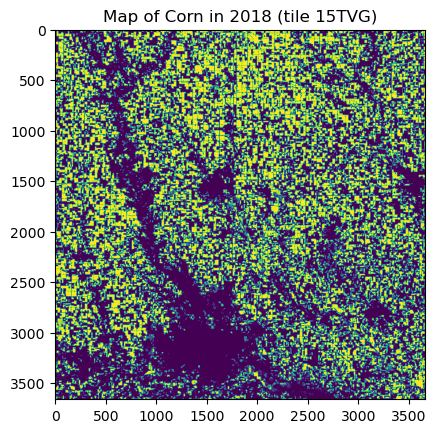

In [29]:
plt.imshow(mask_dict_corn['2018'])
plt.title(f'Map of Corn in 2018 (tile 15TVG)')

In [30]:
save_loc = '../figures/eda-maps'

for year in range(2018,2023):
    file_name = f'corn_mask_{year}.png'
    plt.figure(figsize=(20, 20))
    plt.imshow(mask_dict_corn[str(year)])
    plt.title(f'Map of Corn in {year} (tile 15TVG)', size=20)
    plt.savefig(f'{save_loc}/{file_name}', bbox_inches='tight')
    plt.close()

### Test a certain point

In [41]:
for year in range(2018,2023):
    print(f'--- Readout for year {year} ---')
    is_sure_crop(mask_dict_corn[str(year)],[400,1750])

--- Readout for year 2018 ---
The pixel at 399,1749 is the right crop: True
The pixel at 399,1750 is the right crop: True
The pixel at 399,1751 is the right crop: True
The pixel at 400,1749 is the right crop: True
The pixel at 400,1750 is the right crop: True
The pixel at 400,1751 is the right crop: True
The pixel at 401,1749 is the right crop: True
The pixel at 401,1750 is the right crop: True
The pixel at 401,1751 is the right crop: True
9 out of 9 pixels are the right crop.
--- Readout for year 2019 ---
The pixel at 399,1749 is the right crop: True
The pixel at 399,1750 is the right crop: True
The pixel at 399,1751 is the right crop: True
The pixel at 400,1749 is the right crop: True
The pixel at 400,1750 is the right crop: True
The pixel at 400,1751 is the right crop: True
The pixel at 401,1749 is the right crop: True
The pixel at 401,1750 is the right crop: True
The pixel at 401,1751 is the right crop: True
9 out of 9 pixels are the right crop.
--- Readout for year 2020 ---
The pi

Conclusion: 400,1750 is a good surely-Corn pixel for all years.

### Check volume of crop in the tile

In [33]:
for year in range(2018,2023):
    nbr = sum(sum(mask_dict_corn[str(year)]))
    print(f'In {year}, the CDL shows {nbr} pixels of Corn.')

In 2018, the CDL shows 5175260 pixels of Corn.
In 2019, the CDL shows 5502563 pixels of Corn.
In 2020, the CDL shows 5487299 pixels of Corn.
In 2021, the CDL shows 4841957 pixels of Corn.
In 2022, the CDL shows 4999695 pixels of Corn.
